# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while.
We recommend setting several variables here that prevent repeating long-running tasks.

In [1]:
# device = 'GPU' # TODO change to GPU if you have one (e.g. on Colab)
import torch

# Check for GPU availability
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'   # Fallback to CPU

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [2]:
import sys
import os

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [4]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f


In [5]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw1/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [6]:
!ls

README.md                      hw1_template.tex
__pycache__                    l3d_24f_cpu.yml
best_model.pth                 l3d_24f_cuda.yml
best_model_info.pkl            models.py
birdsnap10                     resnet10-1253-88a5961b.pth
birdsnap10_224x224only.zip     resnet10_cub-2777-4525b593.pth
colab_requirements.txt         resnet26-0849-4bfbc640.pth
data_utils.py                  resnet26_cub-2316-599ab467.pth
hw1.ipynb                      train.py


In [7]:
if COLAB:
    try:
        import torchinfo
        import pytorchcv
    except ImportError:
        rstr = '''
            torchinfo
            pytorchcv
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo
        import pytorchcv
        

In [8]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('./birdsnap10'))
print(DATA_DIR)


/Users/kerwin/Downloads/CS152L3D_2024f/cs152l3d-24f-assignments/hw1/birdsnap10


In [9]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

In [10]:
# Show contents of train set
!ls $DATA_DIR/train/

American_Black_Duck Harlequin_Duck      Prairie_Falcon      White_faced_Ibis
Golden_Eagle        Osprey              Short_eared_Owl
Great_Horned_Owl    Peregrine_Falcon    White_Ibis


# Import Libraries

In [11]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm

In [12]:
import numpy as np
import pandas as pd

In [13]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
# running code locally so need paths to files
import importlib.util
import sys
import os

folder_path = os.path.abspath('')

data_utils_path = os.path.join(folder_path, 'data_utils.py')
spec_data_utils = importlib.util.spec_from_file_location("data_utils", data_utils_path)
data_utils = importlib.util.module_from_spec(spec_data_utils)
sys.modules["data_utils"] = data_utils
spec_data_utils.loader.exec_module(data_utils)

models_path = os.path.join(folder_path, 'models.py')
spec_models = importlib.util.spec_from_file_location("models", models_path)
models = importlib.util.module_from_spec(spec_models)
sys.modules["models"] = models
spec_models.loader.exec_module(models)

train_path = os.path.join(folder_path, 'train.py')
spec_train = importlib.util.spec_from_file_location("train", train_path)
train = importlib.util.module_from_spec(spec_train)
sys.modules["train"] = train
spec_train.loader.exec_module(train)


In [17]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [18]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);

# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [19]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


Pretty-print layer-by-layer info

In [20]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     (3,673,088)
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]        

# Load dataset

In [21]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
(data_utils.BirdsnapDataset(DATA_DIR))

Dataset BirdsnapDataset
    Number of datapoints: 640
    Root location: /Users/kerwin/Downloads/CS152L3D_2024f/cs152l3d-24f-assignments/hw1/birdsnap10

In [22]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 14 14 14 14 14 14 14 14 14 14


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [23]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits_BC = model(x)
            _, predicted = torch.max(logits_BC, 1)
            correct += (predicted == y).sum().item()


    return correct / len(test_loader.dataset) 

In [24]:
print(test_loader)
print(len(test_loader))
print(len(test_loader.dataset))

3
140


In [48]:
print(train_loader)
print(len(train_loader))
print(len(train_loader.dataset))
print(train_loader.batch_size)

7
400
64


# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [54]:
if PROB1_EXPERIMENTS:
    seed = 42
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10_1k, best_info_resnet10_1k = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.0001,
        l2pen_mag = 0.01,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


  1%|          | 1/101 [00:00<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95]

torch.Size([64, 10])


  1%|          | 1/101 [00:00<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=1]

tensor(1.8173, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  1%|          | 1/101 [00:01<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=2]

tensor(1.8171, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  1%|          | 1/101 [00:01<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=3]

tensor(1.8168, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  1%|          | 1/101 [00:02<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=4]

tensor(1.8165, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  1%|          | 1/101 [00:02<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=5]

tensor(1.8162, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  1%|          | 1/101 [00:03<01:09,  1.44it/s, tr_xent=nan, tr_err=nan, va_xent=2.64, va_err=0.95, batch_done=7]

tensor(1.8159, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8156, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  2%|▏         | 2/101 [00:04<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=7]

torch.Size([64, 10])


  2%|▏         | 2/101 [00:04<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=1]

tensor(1.8154, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  2%|▏         | 2/101 [00:05<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=2]

tensor(1.8151, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  2%|▏         | 2/101 [00:05<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=3]

tensor(1.8149, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  2%|▏         | 2/101 [00:06<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=4]

tensor(1.8147, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  2%|▏         | 2/101 [00:06<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=5]

tensor(1.8144, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  2%|▏         | 2/101 [00:07<04:05,  2.48s/it, tr_xent=2.68, tr_err=0.93, va_xent=2.56, va_err=0.94, batch_done=7]

tensor(1.8142, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8140, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  3%|▎         | 3/101 [00:08<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=7]

torch.Size([64, 10])


  3%|▎         | 3/101 [00:08<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=1]

tensor(1.8138, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  3%|▎         | 3/101 [00:09<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=2]

tensor(1.8136, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  3%|▎         | 3/101 [00:09<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=3]

tensor(1.8135, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  3%|▎         | 3/101 [00:10<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=4]

tensor(1.8133, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  3%|▎         | 3/101 [00:10<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=5]

tensor(1.8131, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  3%|▎         | 3/101 [00:11<05:04,  3.11s/it, tr_xent=2.57, tr_err=0.927, va_xent=2.5, va_err=0.95, batch_done=7]

tensor(1.8130, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8128, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  4%|▍         | 4/101 [00:14<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=7]

torch.Size([64, 10])


  4%|▍         | 4/101 [00:17<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=1]

tensor(1.8127, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  4%|▍         | 4/101 [00:17<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=2]

tensor(1.8126, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  4%|▍         | 4/101 [00:18<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=3]

tensor(1.8124, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  4%|▍         | 4/101 [00:34<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=4]

tensor(1.8123, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  4%|▍         | 4/101 [00:35<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=5]

torch.Size([64, 10])
tensor(1.8122, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  4%|▍         | 4/101 [00:37<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=6]

torch.Size([64, 10])
tensor(1.8121, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  4%|▍         | 4/101 [00:38<06:49,  4.23s/it, tr_xent=2.45, tr_err=0.922, va_xent=2.43, va_err=0.93, batch_done=7]

torch.Size([16, 10])
tensor(1.8120, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  5%|▍         | 5/101 [00:40<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=7] 

torch.Size([64, 10])


  5%|▍         | 5/101 [00:40<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=1]

tensor(1.8120, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  5%|▍         | 5/101 [00:41<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=2]

torch.Size([64, 10])
tensor(1.8119, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  5%|▍         | 5/101 [00:41<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=3]

tensor(1.8118, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  5%|▍         | 5/101 [00:41<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=4]

tensor(1.8117, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  5%|▍         | 5/101 [00:42<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=5]

tensor(1.8117, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  5%|▍         | 5/101 [00:43<19:17, 12.06s/it, tr_xent=2.4, tr_err=0.877, va_xent=2.39, va_err=0.91, batch_done=7]

tensor(1.8116, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8116, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  6%|▌         | 6/101 [00:43<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=7]

torch.Size([64, 10])


  6%|▌         | 6/101 [00:44<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=1]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  6%|▌         | 6/101 [00:44<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=2]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  6%|▌         | 6/101 [00:45<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=3]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  6%|▌         | 6/101 [00:45<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=4]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  6%|▌         | 6/101 [00:45<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=5]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  6%|▌         | 6/101 [00:46<14:33,  9.19s/it, tr_xent=2.34, tr_err=0.855, va_xent=2.35, va_err=0.9, batch_done=7]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  7%|▋         | 7/101 [00:47<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=7]

torch.Size([64, 10])


  7%|▋         | 7/101 [00:47<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=1]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  7%|▋         | 7/101 [00:48<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=2]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  7%|▋         | 7/101 [00:48<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=3]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  7%|▋         | 7/101 [00:49<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=4]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  7%|▋         | 7/101 [00:50<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=5]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  7%|▋         | 7/101 [00:50<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=6]

tensor(1.8114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  7%|▋         | 7/101 [00:51<11:28,  7.32s/it, tr_xent=2.26, tr_err=0.828, va_xent=2.3, va_err=0.92, batch_done=7]

torch.Size([16, 10])
tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  8%|▊         | 8/101 [00:53<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=7]

torch.Size([64, 10])


  8%|▊         | 8/101 [00:53<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=1]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  8%|▊         | 8/101 [00:54<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=2]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  8%|▊         | 8/101 [00:55<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=3]

torch.Size([64, 10])


  8%|▊         | 8/101 [00:55<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=4]

tensor(1.8115, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  8%|▊         | 8/101 [00:56<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=5]

tensor(1.8116, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  8%|▊         | 8/101 [00:57<10:44,  6.93s/it, tr_xent=2.27, tr_err=0.81, va_xent=2.26, va_err=0.87, batch_done=7]

tensor(1.8116, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8117, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


  9%|▉         | 9/101 [00:57<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=7]

torch.Size([64, 10])


  9%|▉         | 9/101 [00:58<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=1]

tensor(1.8117, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  9%|▉         | 9/101 [00:58<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=2]

tensor(1.8118, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  9%|▉         | 9/101 [00:59<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=3]

tensor(1.8119, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  9%|▉         | 9/101 [00:59<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=4]

tensor(1.8119, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  9%|▉         | 9/101 [00:59<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=5]

tensor(1.8120, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


  9%|▉         | 9/101 [01:00<09:23,  6.13s/it, tr_xent=2.18, tr_err=0.76, va_xent=2.22, va_err=0.82, batch_done=7]

tensor(1.8121, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8122, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 10%|▉         | 10/101 [01:01<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=7]

torch.Size([64, 10])


 10%|▉         | 10/101 [01:01<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=1]

tensor(1.8123, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 10%|▉         | 10/101 [01:02<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=2]

tensor(1.8125, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 10%|▉         | 10/101 [01:02<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=3]

tensor(1.8126, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 10%|▉         | 10/101 [01:03<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=4]

tensor(1.8127, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 10%|▉         | 10/101 [01:03<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=5]

tensor(1.8128, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 10%|▉         | 10/101 [01:04<08:04,  5.32s/it, tr_xent=2.12, tr_err=0.738, va_xent=2.17, va_err=0.79, batch_done=7]

tensor(1.8129, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8131, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 11%|█         | 11/101 [01:05<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=7]

torch.Size([64, 10])


 11%|█         | 11/101 [01:05<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=1]

tensor(1.8132, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 11%|█         | 11/101 [01:05<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=2]

tensor(1.8134, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 11%|█         | 11/101 [01:06<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=3]

tensor(1.8135, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 11%|█         | 11/101 [01:06<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=4]

tensor(1.8137, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 11%|█         | 11/101 [01:07<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=5]

tensor(1.8138, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 11%|█         | 11/101 [01:07<07:16,  4.85s/it, tr_xent=2.08, tr_err=0.733, va_xent=2.13, va_err=0.77, batch_done=7]

tensor(1.8140, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8142, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 12%|█▏        | 12/101 [01:08<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=7]

torch.Size([64, 10])


 12%|█▏        | 12/101 [01:08<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=1]

tensor(1.8143, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 12%|█▏        | 12/101 [01:09<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=2]

tensor(1.8145, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 12%|█▏        | 12/101 [01:10<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=3]

tensor(1.8147, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 12%|█▏        | 12/101 [01:10<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=4]

tensor(1.8149, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 12%|█▏        | 12/101 [01:11<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=5]

tensor(1.8151, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 12%|█▏        | 12/101 [01:11<06:33,  4.43s/it, tr_xent=2.03, tr_err=0.708, va_xent=2.09, va_err=0.77, batch_done=7]

tensor(1.8153, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8155, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 13%|█▎        | 13/101 [01:12<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=7] 

torch.Size([64, 10])


 13%|█▎        | 13/101 [01:13<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=1]

tensor(1.8157, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 13%|█▎        | 13/101 [01:14<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=2]

tensor(1.8159, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 13%|█▎        | 13/101 [01:14<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=3]

tensor(1.8161, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 13%|█▎        | 13/101 [01:15<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=4]

tensor(1.8163, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(1.8165, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 13%|█▎        | 13/101 [01:15<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=5]

torch.Size([64, 10])


 13%|█▎        | 13/101 [01:16<06:23,  4.35s/it, tr_xent=1.97, tr_err=0.66, va_xent=2.05, va_err=0.75, batch_done=7]

tensor(1.8168, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8170, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 14%|█▍        | 14/101 [01:17<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=7]

torch.Size([64, 10])


 14%|█▍        | 14/101 [01:17<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=1]

tensor(1.8172, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 14%|█▍        | 14/101 [01:18<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=2]

tensor(1.8175, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 14%|█▍        | 14/101 [01:18<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=3]

tensor(1.8177, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 14%|█▍        | 14/101 [01:18<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=4]

tensor(1.8179, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 14%|█▍        | 14/101 [01:19<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=5]

tensor(1.8182, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 14%|█▍        | 14/101 [01:20<06:25,  4.43s/it, tr_xent=1.94, tr_err=0.645, va_xent=2.01, va_err=0.73, batch_done=7]

tensor(1.8184, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8187, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 15%|█▍        | 15/101 [01:20<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=7]

torch.Size([64, 10])


 15%|█▍        | 15/101 [01:21<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=1]

tensor(1.8190, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 15%|█▍        | 15/101 [01:21<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=2]

tensor(1.8192, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 15%|█▍        | 15/101 [01:22<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=3]

tensor(1.8195, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 15%|█▍        | 15/101 [01:22<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=4]

tensor(1.8198, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 15%|█▍        | 15/101 [01:23<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=5]

tensor(1.8200, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(1.8203, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 15%|█▍        | 15/101 [01:25<05:56,  4.14s/it, tr_xent=1.87, tr_err=0.627, va_xent=1.98, va_err=0.69, batch_done=7]

torch.Size([16, 10])
tensor(1.8206, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 16%|█▌        | 16/101 [01:26<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=7]

torch.Size([64, 10])


 16%|█▌        | 16/101 [01:27<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=1]

tensor(1.8209, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 16%|█▌        | 16/101 [01:27<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=2]

tensor(1.8212, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 16%|█▌        | 16/101 [01:28<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=3]

tensor(1.8215, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 16%|█▌        | 16/101 [01:29<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=4]

tensor(1.8217, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 16%|█▌        | 16/101 [01:29<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=5]

tensor(1.8220, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 16%|█▌        | 16/101 [01:30<06:21,  4.49s/it, tr_xent=1.85, tr_err=0.595, va_xent=1.94, va_err=0.63, batch_done=7]

tensor(1.8223, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8226, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 17%|█▋        | 17/101 [01:31<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=7] 

torch.Size([64, 10])


 17%|█▋        | 17/101 [01:31<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=1]

tensor(1.8230, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 17%|█▋        | 17/101 [01:32<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=2]

tensor(1.8233, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 17%|█▋        | 17/101 [01:32<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=3]

tensor(1.8237, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 17%|█▋        | 17/101 [01:33<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=4]

tensor(1.8240, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 17%|█▋        | 17/101 [01:33<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=5]

torch.Size([64, 10])
tensor(1.8243, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 17%|█▋        | 17/101 [01:34<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=6]

tensor(1.8247, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 17%|█▋        | 17/101 [01:34<06:32,  4.68s/it, tr_xent=1.77, tr_err=0.547, va_xent=1.9, va_err=0.59, batch_done=7]

torch.Size([16, 10])
tensor(1.8250, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 18%|█▊        | 18/101 [01:36<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=7]

torch.Size([64, 10])


 18%|█▊        | 18/101 [01:37<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=1]

tensor(1.8254, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 18%|█▊        | 18/101 [01:38<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=2]

tensor(1.8257, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 18%|█▊        | 18/101 [01:39<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=3]

tensor(1.8261, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 18%|█▊        | 18/101 [01:39<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=4]

tensor(1.8264, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 18%|█▊        | 18/101 [01:39<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=5]

tensor(1.8268, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 18%|█▊        | 18/101 [01:40<06:53,  4.99s/it, tr_xent=1.75, tr_err=0.535, va_xent=1.87, va_err=0.57, batch_done=7]

tensor(1.8272, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8275, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 19%|█▉        | 19/101 [01:41<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=7]

torch.Size([64, 10])


 19%|█▉        | 19/101 [01:45<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=1]

tensor(1.8279, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 19%|█▉        | 19/101 [01:45<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=2]

tensor(1.8283, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 19%|█▉        | 19/101 [01:45<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=3]

tensor(1.8286, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 19%|█▉        | 19/101 [01:46<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=4]

tensor(1.8290, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 19%|█▉        | 19/101 [01:47<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=5]

tensor(1.8294, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 19%|█▉        | 19/101 [01:47<06:49,  4.99s/it, tr_xent=1.72, tr_err=0.505, va_xent=1.84, va_err=0.54, batch_done=7]

tensor(1.8298, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8302, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 20%|█▉        | 20/101 [01:48<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=7]

torch.Size([64, 10])


 20%|█▉        | 20/101 [01:48<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=1]

tensor(1.8306, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 20%|█▉        | 20/101 [01:49<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=2]

tensor(1.8310, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 20%|█▉        | 20/101 [01:49<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=3]

torch.Size([64, 10])
tensor(1.8313, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 20%|█▉        | 20/101 [01:50<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=4]

tensor(1.8317, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 20%|█▉        | 20/101 [01:50<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=5]

tensor(1.8321, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 20%|█▉        | 20/101 [01:51<07:26,  5.51s/it, tr_xent=1.68, tr_err=0.463, va_xent=1.81, va_err=0.55, batch_done=7]

tensor(1.8325, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8329, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 21%|██        | 21/101 [01:52<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=7] 

torch.Size([64, 10])


 21%|██        | 21/101 [01:52<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=1]

tensor(1.8334, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 21%|██        | 21/101 [01:53<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=2]

tensor(1.8338, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 21%|██        | 21/101 [01:53<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=3]

tensor(1.8342, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 21%|██        | 21/101 [01:54<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=4]

tensor(1.8346, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 21%|██        | 21/101 [01:54<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=5]

tensor(1.8350, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 21%|██        | 21/101 [01:55<06:39,  4.99s/it, tr_xent=1.64, tr_err=0.46, va_xent=1.78, va_err=0.52, batch_done=7]

tensor(1.8355, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8359, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 22%|██▏       | 22/101 [01:55<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=7]

torch.Size([64, 10])


 22%|██▏       | 22/101 [01:56<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=1]

tensor(1.8363, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(1.8368, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 22%|██▏       | 22/101 [01:56<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=2]

torch.Size([64, 10])


 22%|██▏       | 22/101 [01:57<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=3]

tensor(1.8372, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 22%|██▏       | 22/101 [01:58<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=4]

tensor(1.8377, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 22%|██▏       | 22/101 [01:58<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=5]

tensor(1.8381, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 22%|██▏       | 22/101 [01:59<05:58,  4.54s/it, tr_xent=1.61, tr_err=0.427, va_xent=1.75, va_err=0.51, batch_done=7]

tensor(1.8386, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8390, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 23%|██▎       | 23/101 [02:00<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=7] 

torch.Size([64, 10])


 23%|██▎       | 23/101 [02:01<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=1]

tensor(1.8395, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 23%|██▎       | 23/101 [02:02<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=2]

torch.Size([64, 10])
tensor(1.8399, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 23%|██▎       | 23/101 [02:02<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=3]

tensor(1.8404, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 23%|██▎       | 23/101 [02:03<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=4]

tensor(1.8408, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 23%|██▎       | 23/101 [02:04<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=5]

tensor(1.8413, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 23%|██▎       | 23/101 [02:04<05:55,  4.56s/it, tr_xent=1.59, tr_err=0.42, va_xent=1.72, va_err=0.49, batch_done=7]

tensor(1.8418, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8422, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 24%|██▍       | 24/101 [02:05<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=7]

torch.Size([64, 10])


 24%|██▍       | 24/101 [02:05<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=1]

tensor(1.8427, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 24%|██▍       | 24/101 [02:06<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=2]

tensor(1.8432, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 24%|██▍       | 24/101 [02:06<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=3]

tensor(1.8436, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 24%|██▍       | 24/101 [02:07<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=4]

tensor(1.8441, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 24%|██▍       | 24/101 [02:07<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=5]

tensor(1.8446, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 24%|██▍       | 24/101 [02:08<06:02,  4.71s/it, tr_xent=1.56, tr_err=0.412, va_xent=1.69, va_err=0.46, batch_done=7]

tensor(1.8451, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8455, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 25%|██▍       | 25/101 [02:09<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=7]

torch.Size([64, 10])


 25%|██▍       | 25/101 [02:09<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=1]

tensor(1.8460, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 25%|██▍       | 25/101 [02:09<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=2]

tensor(1.8465, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 25%|██▍       | 25/101 [02:10<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=3]

tensor(1.8470, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 25%|██▍       | 25/101 [02:10<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=4]

tensor(1.8475, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 25%|██▍       | 25/101 [02:11<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=5]

tensor(1.8480, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 25%|██▍       | 25/101 [02:11<05:31,  4.36s/it, tr_xent=1.51, tr_err=0.403, va_xent=1.67, va_err=0.46, batch_done=7]

tensor(1.8485, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8490, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 26%|██▌       | 26/101 [02:12<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=7] 

torch.Size([64, 10])


 26%|██▌       | 26/101 [02:12<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=1]

tensor(1.8495, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 26%|██▌       | 26/101 [02:13<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=2]

tensor(1.8500, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 26%|██▌       | 26/101 [02:13<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=3]

tensor(1.8505, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 26%|██▌       | 26/101 [02:14<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=4]

torch.Size([64, 10])
tensor(1.8510, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 26%|██▌       | 26/101 [02:15<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=5]

tensor(1.8515, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 26%|██▌       | 26/101 [02:15<05:08,  4.11s/it, tr_xent=1.5, tr_err=0.372, va_xent=1.64, va_err=0.43, batch_done=7]

tensor(1.8520, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8525, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 27%|██▋       | 27/101 [02:16<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=7]

torch.Size([64, 10])


 27%|██▋       | 27/101 [02:16<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=1]

tensor(1.8530, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 27%|██▋       | 27/101 [02:17<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=2]

tensor(1.8535, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 27%|██▋       | 27/101 [02:17<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=3]

tensor(1.8540, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 27%|██▋       | 27/101 [02:18<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=4]

tensor(1.8545, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 27%|██▋       | 27/101 [02:18<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=5]

tensor(1.8550, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 27%|██▋       | 27/101 [02:19<04:57,  4.02s/it, tr_xent=1.46, tr_err=0.325, va_xent=1.62, va_err=0.43, batch_done=7]

tensor(1.8556, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8561, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 28%|██▊       | 28/101 [02:20<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=7]

torch.Size([64, 10])


 28%|██▊       | 28/101 [02:20<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=1]

tensor(1.8566, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 28%|██▊       | 28/101 [02:20<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=2]

tensor(1.8571, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 28%|██▊       | 28/101 [02:21<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=3]

tensor(1.8577, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 28%|██▊       | 28/101 [02:21<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=4]

tensor(1.8582, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 28%|██▊       | 28/101 [02:22<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=5]

tensor(1.8587, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 28%|██▊       | 28/101 [02:22<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=6]

tensor(1.8593, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 28%|██▊       | 28/101 [02:23<04:44,  3.90s/it, tr_xent=1.42, tr_err=0.318, va_xent=1.59, va_err=0.45, batch_done=7]

torch.Size([16, 10])
tensor(1.8598, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 29%|██▊       | 29/101 [02:24<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=7]

torch.Size([64, 10])


 29%|██▊       | 29/101 [02:25<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=1]

tensor(1.8603, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 29%|██▊       | 29/101 [02:25<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=2]

tensor(1.8609, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 29%|██▊       | 29/101 [02:26<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=3]

tensor(1.8614, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 29%|██▊       | 29/101 [02:26<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=4]

tensor(1.8620, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 29%|██▊       | 29/101 [02:27<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=5]

tensor(1.8625, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 29%|██▊       | 29/101 [02:27<04:52,  4.07s/it, tr_xent=1.37, tr_err=0.325, va_xent=1.57, va_err=0.41, batch_done=7]

tensor(1.8631, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8636, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 30%|██▉       | 30/101 [02:29<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=7] 

torch.Size([64, 10])


 30%|██▉       | 30/101 [02:30<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=1]

tensor(1.8642, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 30%|██▉       | 30/101 [02:30<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=2]

tensor(1.8647, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 30%|██▉       | 30/101 [02:31<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=3]

tensor(1.8652, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 30%|██▉       | 30/101 [02:31<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=4]

tensor(1.8658, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 30%|██▉       | 30/101 [02:31<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=5]

tensor(1.8663, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 30%|██▉       | 30/101 [02:32<05:08,  4.35s/it, tr_xent=1.43, tr_err=0.31, va_xent=1.55, va_err=0.42, batch_done=7]

tensor(1.8669, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8674, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 31%|███       | 31/101 [02:33<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=7]

torch.Size([64, 10])


 31%|███       | 31/101 [02:33<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=1]

tensor(1.8679, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 31%|███       | 31/101 [02:34<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=2]

tensor(1.8685, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 31%|███       | 31/101 [02:34<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=3]

tensor(1.8690, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 31%|███       | 31/101 [02:35<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=4]

tensor(1.8696, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 31%|███       | 31/101 [02:35<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=5]

tensor(1.8701, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 31%|███       | 31/101 [02:36<04:54,  4.20s/it, tr_xent=1.35, tr_err=0.287, va_xent=1.52, va_err=0.39, batch_done=7]

tensor(1.8707, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8712, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 32%|███▏      | 32/101 [02:36<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=7]

torch.Size([64, 10])


 32%|███▏      | 32/101 [02:37<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=1]

tensor(1.8718, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 32%|███▏      | 32/101 [02:37<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=2]

tensor(1.8723, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 32%|███▏      | 32/101 [02:38<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=3]

tensor(1.8729, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 32%|███▏      | 32/101 [02:38<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=4]

tensor(1.8735, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 32%|███▏      | 32/101 [02:39<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=5]

tensor(1.8740, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 32%|███▏      | 32/101 [02:39<04:33,  3.97s/it, tr_xent=1.32, tr_err=0.273, va_xent=1.51, va_err=0.38, batch_done=7]

tensor(1.8746, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8752, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 33%|███▎      | 33/101 [02:40<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=7] 

torch.Size([64, 10])


 33%|███▎      | 33/101 [02:41<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=1]

tensor(1.8757, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 33%|███▎      | 33/101 [02:41<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=2]

tensor(1.8763, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 33%|███▎      | 33/101 [02:42<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=3]

tensor(1.8768, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 33%|███▎      | 33/101 [02:42<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=4]

tensor(1.8774, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 33%|███▎      | 33/101 [02:42<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=5]

tensor(1.8780, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 33%|███▎      | 33/101 [02:43<04:29,  3.96s/it, tr_xent=1.3, tr_err=0.273, va_xent=1.48, va_err=0.38, batch_done=7]

tensor(1.8786, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8791, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 34%|███▎      | 34/101 [02:45<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=7]

torch.Size([64, 10])


 34%|███▎      | 34/101 [02:45<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=1]

tensor(1.8797, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 34%|███▎      | 34/101 [02:46<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=2]

tensor(1.8803, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 34%|███▎      | 34/101 [02:46<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=3]

tensor(1.8808, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 34%|███▎      | 34/101 [02:47<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=4]

tensor(1.8814, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 34%|███▎      | 34/101 [02:47<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=5]

tensor(1.8820, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 34%|███▎      | 34/101 [02:48<04:34,  4.09s/it, tr_xent=1.31, tr_err=0.255, va_xent=1.46, va_err=0.37, batch_done=7]

tensor(1.8826, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8832, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 35%|███▍      | 35/101 [02:48<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 35%|███▍      | 35/101 [02:49<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=1]

tensor(1.8837, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 35%|███▍      | 35/101 [02:49<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=2]

tensor(1.8843, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 35%|███▍      | 35/101 [02:50<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=3]

tensor(1.8849, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 35%|███▍      | 35/101 [02:50<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=4]

tensor(1.8855, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 35%|███▍      | 35/101 [02:51<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=5]

tensor(1.8861, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 35%|███▍      | 35/101 [02:52<04:24,  4.01s/it, tr_xent=1.26, tr_err=0.247, va_xent=1.45, va_err=0.35, batch_done=7]

tensor(1.8867, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8873, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 36%|███▌      | 36/101 [02:53<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 36%|███▌      | 36/101 [02:53<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=1]

tensor(1.8879, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 36%|███▌      | 36/101 [02:53<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=2]

tensor(1.8885, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 36%|███▌      | 36/101 [02:54<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=3]

tensor(1.8891, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 36%|███▌      | 36/101 [02:54<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=4]

tensor(1.8897, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 36%|███▌      | 36/101 [02:55<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=5]

tensor(1.8903, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 36%|███▌      | 36/101 [02:56<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=6]

tensor(1.8909, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 36%|███▌      | 36/101 [02:56<04:22,  4.05s/it, tr_xent=1.23, tr_err=0.263, va_xent=1.43, va_err=0.35, batch_done=7]

torch.Size([16, 10])
tensor(1.8915, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 37%|███▋      | 37/101 [02:58<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 37%|███▋      | 37/101 [02:59<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=1]

tensor(1.8921, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 37%|███▋      | 37/101 [02:59<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=2]

tensor(1.8927, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 37%|███▋      | 37/101 [03:00<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=3]

torch.Size([64, 10])
tensor(1.8933, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 37%|███▋      | 37/101 [03:00<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=4]

tensor(1.8939, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 37%|███▋      | 37/101 [03:01<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=5]

tensor(1.8946, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 37%|███▋      | 37/101 [03:01<04:45,  4.46s/it, tr_xent=1.21, tr_err=0.242, va_xent=1.41, va_err=0.35, batch_done=7]

tensor(1.8952, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.8958, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 38%|███▊      | 38/101 [03:02<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=7]  

torch.Size([64, 10])


 38%|███▊      | 38/101 [03:02<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=1]

tensor(1.8964, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 38%|███▊      | 38/101 [03:03<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=2]

tensor(1.8970, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 38%|███▊      | 38/101 [03:03<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=3]

tensor(1.8976, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 38%|███▊      | 38/101 [03:04<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=4]

tensor(1.8982, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 38%|███▊      | 38/101 [03:04<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=5]

tensor(1.8988, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 38%|███▊      | 38/101 [03:05<04:35,  4.37s/it, tr_xent=1.2, tr_err=0.23, va_xent=1.39, va_err=0.34, batch_done=7]

tensor(1.8995, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9001, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 39%|███▊      | 39/101 [03:05<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 39%|███▊      | 39/101 [03:06<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=1]

tensor(1.9007, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 39%|███▊      | 39/101 [03:06<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=2]

tensor(1.9013, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 39%|███▊      | 39/101 [03:07<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=3]

tensor(1.9019, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 39%|███▊      | 39/101 [03:07<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=4]

tensor(1.9026, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 39%|███▊      | 39/101 [03:07<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=5]

tensor(1.9032, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 39%|███▊      | 39/101 [03:08<04:10,  4.04s/it, tr_xent=1.18, tr_err=0.22, va_xent=1.37, va_err=0.35, batch_done=7]

tensor(1.9038, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9044, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 40%|███▉      | 40/101 [03:08<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 40%|███▉      | 40/101 [03:09<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=1]

tensor(1.9051, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 40%|███▉      | 40/101 [03:09<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=2]

tensor(1.9057, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 40%|███▉      | 40/101 [03:10<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=3]

tensor(1.9063, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 40%|███▉      | 40/101 [03:10<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=4]

tensor(1.9069, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 40%|███▉      | 40/101 [03:10<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=5]

tensor(1.9076, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 40%|███▉      | 40/101 [03:11<03:48,  3.75s/it, tr_xent=1.14, tr_err=0.237, va_xent=1.36, va_err=0.35, batch_done=7]

tensor(1.9082, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9088, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 41%|████      | 41/101 [03:12<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=7]

torch.Size([64, 10])


 41%|████      | 41/101 [03:12<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=1]

tensor(1.9095, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 41%|████      | 41/101 [03:12<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=2]

tensor(1.9101, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 41%|████      | 41/101 [03:13<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=3]

tensor(1.9107, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 41%|████      | 41/101 [03:13<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=4]

tensor(1.9114, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 41%|████      | 41/101 [03:14<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=5]

tensor(1.9120, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 41%|████      | 41/101 [03:14<03:33,  3.56s/it, tr_xent=1.11, tr_err=0.228, va_xent=1.34, va_err=0.34, batch_done=7]

tensor(1.9127, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9133, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 42%|████▏     | 42/101 [03:15<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=7]

torch.Size([64, 10])


 42%|████▏     | 42/101 [03:15<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=1]

tensor(1.9140, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 42%|████▏     | 42/101 [03:16<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=2]

tensor(1.9146, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 42%|████▏     | 42/101 [03:16<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=3]

tensor(1.9152, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 42%|████▏     | 42/101 [03:16<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=4]

tensor(1.9158, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 42%|████▏     | 42/101 [03:17<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=5]

tensor(1.9165, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 42%|████▏     | 42/101 [03:17<03:23,  3.45s/it, tr_xent=1.11, tr_err=0.217, va_xent=1.32, va_err=0.34, batch_done=7]

tensor(1.9171, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9178, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 43%|████▎     | 43/101 [03:18<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=7]

torch.Size([64, 10])


 43%|████▎     | 43/101 [03:19<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=1]

tensor(1.9184, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 43%|████▎     | 43/101 [03:19<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=2]

tensor(1.9190, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 43%|████▎     | 43/101 [03:20<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=3]

tensor(1.9196, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 43%|████▎     | 43/101 [03:20<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=4]

tensor(1.9203, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 43%|████▎     | 43/101 [03:21<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=5]

tensor(1.9209, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 43%|████▎     | 43/101 [03:21<03:19,  3.44s/it, tr_xent=1.11, tr_err=0.215, va_xent=1.31, va_err=0.35, batch_done=7]

tensor(1.9216, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9222, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 44%|████▎     | 44/101 [03:22<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=7]

torch.Size([64, 10])


 44%|████▎     | 44/101 [03:22<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=1]

tensor(1.9229, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 44%|████▎     | 44/101 [03:23<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=2]

tensor(1.9235, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 44%|████▎     | 44/101 [03:23<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=3]

tensor(1.9242, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 44%|████▎     | 44/101 [03:24<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=4]

tensor(1.9248, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 44%|████▎     | 44/101 [03:24<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=5]

tensor(1.9254, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 44%|████▎     | 44/101 [03:25<03:19,  3.50s/it, tr_xent=1.07, tr_err=0.195, va_xent=1.29, va_err=0.34, batch_done=7]

tensor(1.9261, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9267, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 45%|████▍     | 45/101 [03:25<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=7]

torch.Size([64, 10])


 45%|████▍     | 45/101 [03:26<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=1]

tensor(1.9274, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 45%|████▍     | 45/101 [03:26<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=2]

tensor(1.9281, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 45%|████▍     | 45/101 [03:26<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=3]

tensor(1.9287, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 45%|████▍     | 45/101 [03:27<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=4]

tensor(1.9294, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 45%|████▍     | 45/101 [03:27<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=5]

tensor(1.9300, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 45%|████▍     | 45/101 [03:28<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=6]

tensor(1.9307, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 45%|████▍     | 45/101 [03:29<03:14,  3.47s/it, tr_xent=1.05, tr_err=0.193, va_xent=1.28, va_err=0.34, batch_done=7]

torch.Size([16, 10])
tensor(1.9313, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 46%|████▌     | 46/101 [03:30<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=7]

torch.Size([64, 10])


 46%|████▌     | 46/101 [03:31<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=1]

tensor(1.9320, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 46%|████▌     | 46/101 [03:31<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=2]

tensor(1.9327, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 46%|████▌     | 46/101 [03:32<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=3]

tensor(1.9333, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 46%|████▌     | 46/101 [03:32<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=4]

tensor(1.9340, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 46%|████▌     | 46/101 [03:32<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=5]

tensor(1.9346, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 46%|████▌     | 46/101 [03:33<03:33,  3.87s/it, tr_xent=1.06, tr_err=0.185, va_xent=1.26, va_err=0.33, batch_done=7]

tensor(1.9353, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9360, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 47%|████▋     | 47/101 [03:34<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=7]

torch.Size([64, 10])


 47%|████▋     | 47/101 [03:34<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=1]

tensor(1.9366, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 47%|████▋     | 47/101 [03:34<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=2]

tensor(1.9373, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 47%|████▋     | 47/101 [03:35<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=3]

tensor(1.9379, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 47%|████▋     | 47/101 [03:35<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=4]

tensor(1.9386, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 47%|████▋     | 47/101 [03:35<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=5]

tensor(1.9393, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 47%|████▋     | 47/101 [03:36<03:22,  3.75s/it, tr_xent=1.01, tr_err=0.182, va_xent=1.25, va_err=0.33, batch_done=7]

tensor(1.9399, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9406, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 48%|████▊     | 48/101 [03:37<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=7]

torch.Size([64, 10])


 48%|████▊     | 48/101 [03:37<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=1]

tensor(1.9412, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 48%|████▊     | 48/101 [03:38<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=2]

tensor(1.9419, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 48%|████▊     | 48/101 [03:38<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=3]

tensor(1.9425, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 48%|████▊     | 48/101 [03:39<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=4]

tensor(1.9432, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 48%|████▊     | 48/101 [03:39<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=5]

tensor(1.9439, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(1.9445, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 48%|████▊     | 48/101 [03:40<03:10,  3.60s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.24, va_err=0.33, batch_done=7]

torch.Size([16, 10])
tensor(1.9452, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 49%|████▊     | 49/101 [03:41<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=7]

torch.Size([64, 10])


 49%|████▊     | 49/101 [03:41<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=1]

tensor(1.9458, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 49%|████▊     | 49/101 [03:42<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=2]

tensor(1.9465, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 49%|████▊     | 49/101 [03:42<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=3]

tensor(1.9471, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 49%|████▊     | 49/101 [03:42<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=4]

tensor(1.9477, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 49%|████▊     | 49/101 [03:43<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=5]

tensor(1.9484, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 49%|████▊     | 49/101 [03:44<03:13,  3.72s/it, tr_xent=1.02, tr_err=0.177, va_xent=1.22, va_err=0.32, batch_done=7]

tensor(1.9491, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9497, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 50%|████▉     | 50/101 [03:44<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=7]

torch.Size([64, 10])


 50%|████▉     | 50/101 [03:45<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=1]

tensor(1.9503, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|████▉     | 50/101 [03:45<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=2]

tensor(1.9510, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|████▉     | 50/101 [03:46<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=3]

tensor(1.9517, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|████▉     | 50/101 [03:46<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=4]

tensor(1.9523, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|████▉     | 50/101 [03:46<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=5]

tensor(1.9530, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|████▉     | 50/101 [03:47<03:09,  3.72s/it, tr_xent=1.01, tr_err=0.175, va_xent=1.21, va_err=0.32, batch_done=7]

tensor(1.9536, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9543, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 50%|█████     | 51/101 [03:48<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=7]

torch.Size([64, 10])


 50%|█████     | 51/101 [03:48<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=1]

tensor(1.9549, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|█████     | 51/101 [03:48<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=2]

tensor(1.9556, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|█████     | 51/101 [03:49<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=3]

tensor(1.9562, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|█████     | 51/101 [03:49<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=4]

tensor(1.9569, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|█████     | 51/101 [03:50<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=5]

tensor(1.9576, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 50%|█████     | 51/101 [03:50<02:58,  3.56s/it, tr_xent=0.954, tr_err=0.152, va_xent=1.2, va_err=0.31, batch_done=7]

tensor(1.9582, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9589, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 51%|█████▏    | 52/101 [03:51<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=7]

torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:52<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=1]

tensor(1.9596, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:53<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=2]

tensor(1.9602, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:53<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=3]

tensor(1.9609, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:54<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=4]

tensor(1.9616, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:55<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=5]

tensor(1.9623, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 51%|█████▏    | 52/101 [03:55<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=6]

tensor(1.9630, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 51%|█████▏    | 52/101 [03:56<02:55,  3.59s/it, tr_xent=0.939, tr_err=0.15, va_xent=1.19, va_err=0.31, batch_done=7]

torch.Size([16, 10])
tensor(1.9636, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 52%|█████▏    | 53/101 [03:56<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=7]

torch.Size([64, 10])


 52%|█████▏    | 53/101 [03:57<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=1]

tensor(1.9643, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 52%|█████▏    | 53/101 [03:58<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=2]

tensor(1.9650, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 52%|█████▏    | 53/101 [03:59<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=3]

tensor(1.9657, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 52%|█████▏    | 53/101 [03:59<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=4]

tensor(1.9663, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 52%|█████▏    | 53/101 [04:00<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=5]

tensor(1.9670, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 52%|█████▏    | 53/101 [04:00<03:14,  4.05s/it, tr_xent=0.909, tr_err=0.158, va_xent=1.18, va_err=0.31, batch_done=7]

tensor(1.9677, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9684, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 53%|█████▎    | 54/101 [04:01<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=7] 

torch.Size([64, 10])


 53%|█████▎    | 54/101 [04:02<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=1]

tensor(1.9690, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 53%|█████▎    | 54/101 [04:03<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=2]

torch.Size([64, 10])
tensor(1.9697, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 53%|█████▎    | 54/101 [04:03<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=3]

tensor(1.9704, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 53%|█████▎    | 54/101 [04:04<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=4]

tensor(1.9711, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 53%|█████▎    | 54/101 [04:04<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=5]

tensor(1.9718, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 53%|█████▎    | 54/101 [04:05<03:19,  4.25s/it, tr_xent=0.96, tr_err=0.158, va_xent=1.17, va_err=0.32, batch_done=7]

tensor(1.9724, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9731, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 54%|█████▍    | 55/101 [04:05<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=7]

torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:06<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=1]

tensor(1.9738, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:06<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=2]

tensor(1.9745, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:07<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=3]

tensor(1.9752, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:07<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=4]

tensor(1.9759, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:07<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=5]

tensor(1.9765, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 54%|█████▍    | 55/101 [04:08<03:14,  4.24s/it, tr_xent=0.917, tr_err=0.135, va_xent=1.16, va_err=0.31, batch_done=7]

tensor(1.9772, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9779, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 55%|█████▌    | 56/101 [04:09<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=7]  

torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:09<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=1]

tensor(1.9786, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:10<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=2]

tensor(1.9793, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:11<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=3]

tensor(1.9800, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:12<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=4]

tensor(1.9807, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:12<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=5]

tensor(1.9814, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 55%|█████▌    | 56/101 [04:13<02:59,  3.98s/it, tr_xent=0.918, tr_err=0.13, va_xent=1.15, va_err=0.3, batch_done=7]

tensor(1.9821, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9828, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 56%|█████▋    | 57/101 [04:13<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=7]

torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:14<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=1]

tensor(1.9835, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:14<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=2]

tensor(1.9842, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:15<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=3]

tensor(1.9849, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:15<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=4]

tensor(1.9856, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:16<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=5]

tensor(1.9862, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 56%|█████▋    | 57/101 [04:17<03:03,  4.18s/it, tr_xent=0.866, tr_err=0.135, va_xent=1.13, va_err=0.3, batch_done=7]

tensor(1.9869, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9876, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 57%|█████▋    | 58/101 [04:18<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=7]

torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:18<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=1]

tensor(1.9883, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:19<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=2]

tensor(1.9890, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:20<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=3]

tensor(1.9896, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:20<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=4]

tensor(1.9903, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:21<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=5]

tensor(1.9910, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 57%|█████▋    | 58/101 [04:21<03:03,  4.26s/it, tr_xent=0.887, tr_err=0.158, va_xent=1.13, va_err=0.3, batch_done=7]

tensor(1.9917, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(1.9924, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 58%|█████▊    | 59/101 [04:22<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=7]

torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:22<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=1]

tensor(1.9930, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:23<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=2]

tensor(1.9937, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:23<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=3]

tensor(1.9944, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:24<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=4]

tensor(1.9951, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:24<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=5]

tensor(1.9957, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 58%|█████▊    | 59/101 [04:25<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=6]

tensor(1.9964, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])


 58%|█████▊    | 59/101 [04:26<02:55,  4.19s/it, tr_xent=0.885, tr_err=0.135, va_xent=1.12, va_err=0.3, batch_done=7]

tensor(1.9971, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 59%|█████▉    | 60/101 [04:27<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=7]

torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:28<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=1]

tensor(1.9978, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:28<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=2]

tensor(1.9984, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:29<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=3]

tensor(1.9991, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:30<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=4]

tensor(1.9998, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:30<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=5]

tensor(2.0005, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 59%|█████▉    | 60/101 [04:31<03:05,  4.52s/it, tr_xent=0.844, tr_err=0.152, va_xent=1.11, va_err=0.31, batch_done=7]

tensor(2.0011, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0018, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 60%|██████    | 61/101 [04:32<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=7] 

torch.Size([64, 10])


 60%|██████    | 61/101 [04:32<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=1]

tensor(2.0025, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 60%|██████    | 61/101 [04:33<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=2]

tensor(2.0032, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 60%|██████    | 61/101 [04:34<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=3]

tensor(2.0038, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 60%|██████    | 61/101 [04:35<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=4]

tensor(2.0045, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 60%|██████    | 61/101 [04:36<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=5]

tensor(2.0052, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 60%|██████    | 61/101 [04:37<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=6]

tensor(2.0058, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 60%|██████    | 61/101 [04:38<03:03,  4.60s/it, tr_xent=0.845, tr_err=0.133, va_xent=1.1, va_err=0.31, batch_done=7]

torch.Size([16, 10])
tensor(2.0065, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 61%|██████▏   | 62/101 [04:44<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=7]

torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:45<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=1]

tensor(2.0072, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:46<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=2]

tensor(2.0078, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:47<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=3]

tensor(2.0085, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:47<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=4]

tensor(2.0092, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:48<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=5]

tensor(2.0098, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 61%|██████▏   | 62/101 [04:48<04:22,  6.73s/it, tr_xent=0.828, tr_err=0.14, va_xent=1.08, va_err=0.29, batch_done=7]

tensor(2.0105, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0112, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 62%|██████▏   | 63/101 [04:49<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=7]

torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:50<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=1]

tensor(2.0119, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:50<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=2]

tensor(2.0125, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:50<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=3]

tensor(2.0132, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:51<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=4]

tensor(2.0139, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:51<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=5]

tensor(2.0146, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 62%|██████▏   | 63/101 [04:52<04:01,  6.35s/it, tr_xent=0.835, tr_err=0.115, va_xent=1.07, va_err=0.29, batch_done=7]

tensor(2.0152, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0159, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 63%|██████▎   | 64/101 [04:53<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=7]  

torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:53<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=1]

tensor(2.0166, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:53<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=2]

tensor(2.0173, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:54<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=3]

tensor(2.0179, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:54<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=4]

tensor(2.0186, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:55<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=5]

tensor(2.0193, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 63%|██████▎   | 64/101 [04:56<03:22,  5.48s/it, tr_xent=0.811, tr_err=0.14, va_xent=1.06, va_err=0.3, batch_done=7]

tensor(2.0200, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0207, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 64%|██████▍   | 65/101 [04:58<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=7]

torch.Size([64, 10])


 64%|██████▍   | 65/101 [04:58<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=1]

tensor(2.0214, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 64%|██████▍   | 65/101 [04:59<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=2]

tensor(2.0220, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 64%|██████▍   | 65/101 [04:59<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=3]

torch.Size([64, 10])
tensor(2.0227, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 64%|██████▍   | 65/101 [05:00<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=4]

tensor(2.0234, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 64%|██████▍   | 65/101 [05:00<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=5]

tensor(2.0241, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 64%|██████▍   | 65/101 [05:01<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=6]

tensor(2.0248, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 64%|██████▍   | 65/101 [05:01<03:14,  5.40s/it, tr_xent=0.788, tr_err=0.133, va_xent=1.06, va_err=0.28, batch_done=7]

torch.Size([16, 10])
tensor(2.0255, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 65%|██████▌   | 66/101 [05:02<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=7]

torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:02<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=1]

tensor(2.0262, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:03<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=2]

tensor(2.0268, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:03<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=3]

tensor(2.0275, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:03<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=4]

tensor(2.0282, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:04<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=5]

tensor(2.0289, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 65%|██████▌   | 66/101 [05:04<02:53,  4.96s/it, tr_xent=0.778, tr_err=0.105, va_xent=1.05, va_err=0.29, batch_done=7]

tensor(2.0296, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0303, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 66%|██████▋   | 67/101 [05:06<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=1]

torch.Size([64, 10])
tensor(2.0309, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 66%|██████▋   | 67/101 [05:06<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=2]

tensor(2.0316, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 66%|██████▋   | 67/101 [05:06<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=3]

tensor(2.0323, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 66%|██████▋   | 67/101 [05:07<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=4]

tensor(2.0330, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 66%|██████▋   | 67/101 [05:07<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=5]

tensor(2.0337, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 66%|██████▋   | 67/101 [05:08<02:32,  4.50s/it, tr_xent=0.774, tr_err=0.128, va_xent=1.04, va_err=0.29, batch_done=7]

tensor(2.0344, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0351, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 67%|██████▋   | 68/101 [05:09<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=7] 

torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:09<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=1]

tensor(2.0357, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:09<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=2]

tensor(2.0364, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:10<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=3]

tensor(2.0371, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:10<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=4]

tensor(2.0378, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:11<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=5]

tensor(2.0384, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 67%|██████▋   | 68/101 [05:11<02:18,  4.20s/it, tr_xent=0.753, tr_err=0.11, va_xent=1.03, va_err=0.28, batch_done=7]

tensor(2.0391, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0398, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 68%|██████▊   | 69/101 [05:12<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=7]

torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:12<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=1]

tensor(2.0405, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:13<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=2]

tensor(2.0412, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:13<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=3]

tensor(2.0419, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:13<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=4]

tensor(2.0425, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:14<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=5]

tensor(2.0432, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 68%|██████▊   | 69/101 [05:15<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=6]

tensor(2.0439, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 68%|██████▊   | 69/101 [05:15<02:03,  3.87s/it, tr_xent=0.745, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=7]

torch.Size([16, 10])
tensor(2.0446, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 69%|██████▉   | 70/101 [05:16<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=7]  

torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:17<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=1]

tensor(2.0453, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:19<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=2]

tensor(2.0460, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:20<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=3]

tensor(2.0467, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:20<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=4]

tensor(2.0474, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:21<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=5]

tensor(2.0481, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 69%|██████▉   | 70/101 [05:23<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=6]

tensor(2.0488, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 69%|██████▉   | 70/101 [05:23<02:05,  4.04s/it, tr_xent=0.76, tr_err=0.11, va_xent=1.02, va_err=0.29, batch_done=7]

torch.Size([16, 10])
tensor(2.0495, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 70%|███████   | 71/101 [05:24<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=7]

torch.Size([64, 10])


 70%|███████   | 71/101 [05:25<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=1]

tensor(2.0501, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 70%|███████   | 71/101 [05:25<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=2]

tensor(2.0508, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 70%|███████   | 71/101 [05:26<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=3]

tensor(2.0515, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 70%|███████   | 71/101 [05:27<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=4]

tensor(2.0522, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 70%|███████   | 71/101 [05:27<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=5]

tensor(2.0529, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 70%|███████   | 71/101 [05:28<02:39,  5.32s/it, tr_xent=0.736, tr_err=0.122, va_xent=1.01, va_err=0.28, batch_done=7]

tensor(2.0536, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0543, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 71%|███████▏  | 72/101 [05:29<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=7]  

torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:29<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=1]

tensor(2.0549, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:30<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=2]

tensor(2.0556, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:30<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=3]

tensor(2.0563, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:31<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=4]

tensor(2.0570, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:32<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=5]

tensor(2.0577, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 71%|███████▏  | 72/101 [05:32<02:26,  5.05s/it, tr_xent=0.749, tr_err=0.0975, va_xent=1, va_err=0.27, batch_done=7]

tensor(2.0584, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0590, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 72%|███████▏  | 73/101 [05:33<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=7]  

torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:34<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=1]

tensor(2.0597, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:34<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=2]

tensor(2.0604, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:34<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=3]

tensor(2.0611, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:35<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=4]

tensor(2.0618, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:35<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=5]

tensor(2.0624, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 72%|███████▏  | 73/101 [05:36<02:14,  4.81s/it, tr_xent=0.739, tr_err=0.11, va_xent=1, va_err=0.27, batch_done=7]

tensor(2.0631, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0638, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 73%|███████▎  | 74/101 [05:36<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=7]

torch.Size([64, 10])


 73%|███████▎  | 74/101 [05:37<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=1]

tensor(2.0645, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(2.0651, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 73%|███████▎  | 74/101 [05:38<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=2]

torch.Size([64, 10])


 73%|███████▎  | 74/101 [05:39<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=3]

tensor(2.0658, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 73%|███████▎  | 74/101 [05:39<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=4]

tensor(2.0665, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 73%|███████▎  | 74/101 [05:40<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=5]

tensor(2.0671, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 73%|███████▎  | 74/101 [05:40<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=6]

tensor(2.0678, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])


 73%|███████▎  | 74/101 [05:41<01:57,  4.37s/it, tr_xent=0.7, tr_err=0.107, va_xent=0.989, va_err=0.27, batch_done=7]

tensor(2.0685, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 74%|███████▍  | 75/101 [05:42<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=7]

torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:43<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=1]

tensor(2.0691, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:43<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=2]

tensor(2.0698, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:44<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=3]

tensor(2.0705, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:44<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=4]

tensor(2.0711, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:45<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=5]

tensor(2.0718, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 74%|███████▍  | 75/101 [05:45<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=6]

tensor(2.0725, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 74%|███████▍  | 75/101 [05:46<02:02,  4.70s/it, tr_xent=0.717, tr_err=0.1, va_xent=0.985, va_err=0.27, batch_done=7]

torch.Size([16, 10])
tensor(2.0731, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 75%|███████▌  | 76/101 [05:49<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=7]

torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:50<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=1]

tensor(2.0738, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:51<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=2]

tensor(2.0745, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:51<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=3]

tensor(2.0751, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:52<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=4]

tensor(2.0758, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:52<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=5]

tensor(2.0765, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 75%|███████▌  | 76/101 [05:53<02:11,  5.25s/it, tr_xent=0.736, tr_err=0.0925, va_xent=0.977, va_err=0.28, batch_done=7]

tensor(2.0771, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0778, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 76%|███████▌  | 77/101 [05:54<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=7] 

torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:54<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=1]

tensor(2.0785, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:54<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=2]

tensor(2.0792, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:55<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=3]

tensor(2.0798, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:55<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=4]

tensor(2.0805, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:56<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=5]

tensor(2.0812, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 76%|███████▌  | 77/101 [05:56<02:04,  5.18s/it, tr_xent=0.731, tr_err=0.105, va_xent=0.973, va_err=0.26, batch_done=7]

tensor(2.0819, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0826, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 77%|███████▋  | 78/101 [05:57<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=7]

torch.Size([64, 10])


 77%|███████▋  | 78/101 [05:57<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=1]

tensor(2.0832, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 77%|███████▋  | 78/101 [05:57<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=2]

tensor(2.0839, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 77%|███████▋  | 78/101 [05:58<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=3]

tensor(2.0846, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 77%|███████▋  | 78/101 [05:58<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=4]

tensor(2.0853, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 77%|███████▋  | 78/101 [05:59<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=5]

tensor(2.0859, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 77%|███████▋  | 78/101 [06:00<01:45,  4.58s/it, tr_xent=0.675, tr_err=0.102, va_xent=0.967, va_err=0.25, batch_done=7]

tensor(2.0866, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0873, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 78%|███████▊  | 79/101 [06:00<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=7]

torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:01<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=1]

tensor(2.0880, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:01<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=2]

tensor(2.0887, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:02<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=3]

tensor(2.0893, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:02<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=4]

tensor(2.0900, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:03<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=5]

tensor(2.0907, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 78%|███████▊  | 79/101 [06:03<01:34,  4.29s/it, tr_xent=0.714, tr_err=0.0975, va_xent=0.962, va_err=0.28, batch_done=6]

tensor(2.0913, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0920, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 79%|███████▉  | 80/101 [06:04<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=7] 

torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:05<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=1]

tensor(2.0927, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:05<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=2]

tensor(2.0933, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:06<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=3]

tensor(2.0940, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:07<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=4]

tensor(2.0947, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:07<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=5]

tensor(2.0954, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 79%|███████▉  | 80/101 [06:08<01:29,  4.25s/it, tr_xent=0.703, tr_err=0.107, va_xent=0.956, va_err=0.28, batch_done=7]

tensor(2.0960, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.0967, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 80%|████████  | 81/101 [06:09<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=7]

torch.Size([64, 10])


 80%|████████  | 81/101 [06:09<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=1]

tensor(2.0973, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 80%|████████  | 81/101 [06:09<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=2]

tensor(2.0980, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 80%|████████  | 81/101 [06:10<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=3]

tensor(2.0986, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 80%|████████  | 81/101 [06:10<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=4]

tensor(2.0993, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 80%|████████  | 81/101 [06:11<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=5]

tensor(2.1000, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 80%|████████  | 81/101 [06:11<01:24,  4.23s/it, tr_xent=0.676, tr_err=0.117, va_xent=0.948, va_err=0.28, batch_done=7]

tensor(2.1006, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1013, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 81%|████████  | 82/101 [06:12<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=7]

torch.Size([64, 10])


 81%|████████  | 82/101 [06:12<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=1]

tensor(2.1020, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 81%|████████  | 82/101 [06:13<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=2]

tensor(2.1026, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 81%|████████  | 82/101 [06:13<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=3]

tensor(2.1033, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 81%|████████  | 82/101 [06:14<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=4]

tensor(2.1039, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 81%|████████  | 82/101 [06:15<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=5]

tensor(2.1046, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 81%|████████  | 82/101 [06:15<01:15,  3.98s/it, tr_xent=0.673, tr_err=0.102, va_xent=0.944, va_err=0.24, batch_done=7]

tensor(2.1052, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1059, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 82%|████████▏ | 83/101 [06:16<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=7] 

torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:16<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=1]

tensor(2.1066, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:17<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=2]

tensor(2.1072, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:17<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=3]

tensor(2.1079, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:18<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=4]

tensor(2.1085, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:18<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=5]

tensor(2.1092, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 82%|████████▏ | 83/101 [06:19<01:11,  3.98s/it, tr_xent=0.644, tr_err=0.09, va_xent=0.937, va_err=0.23, batch_done=7]

tensor(2.1099, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1105, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 83%|████████▎ | 84/101 [06:20<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=7]

torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:20<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=1]

tensor(2.1112, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:21<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=2]

tensor(2.1119, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:21<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=3]

tensor(2.1126, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:22<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=4]

tensor(2.1132, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:22<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=5]

tensor(2.1139, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 83%|████████▎ | 84/101 [06:23<01:07,  3.95s/it, tr_xent=0.653, tr_err=0.115, va_xent=0.93, va_err=0.23, batch_done=7]

tensor(2.1146, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1153, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 84%|████████▍ | 85/101 [06:23<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=7] 

torch.Size([64, 10])
tensor(2.1159, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 84%|████████▍ | 85/101 [06:24<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=2]

torch.Size([64, 10])
tensor(2.1166, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 84%|████████▍ | 85/101 [06:25<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=3]

tensor(2.1173, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 84%|████████▍ | 85/101 [06:25<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=4]

tensor(2.1179, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 84%|████████▍ | 85/101 [06:26<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=5]

tensor(2.1186, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 84%|████████▍ | 85/101 [06:33<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=6]

tensor(2.1193, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])


 84%|████████▍ | 85/101 [06:34<01:01,  3.82s/it, tr_xent=0.613, tr_err=0.1, va_xent=0.919, va_err=0.23, batch_done=7]

tensor(2.1199, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 85%|████████▌ | 86/101 [06:42<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=7]

torch.Size([64, 10])


 85%|████████▌ | 86/101 [06:43<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=1]

tensor(2.1206, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 85%|████████▌ | 86/101 [06:43<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=2]

tensor(2.1213, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 85%|████████▌ | 86/101 [06:44<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=3]

tensor(2.1219, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 85%|████████▌ | 86/101 [06:44<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=4]

tensor(2.1226, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 85%|████████▌ | 86/101 [06:45<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=5]

tensor(2.1233, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(2.1240, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 85%|████████▌ | 86/101 [06:46<02:02,  8.19s/it, tr_xent=0.626, tr_err=0.0925, va_xent=0.91, va_err=0.24, batch_done=7]

torch.Size([16, 10])
tensor(2.1246, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 86%|████████▌ | 87/101 [06:48<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=1] 

torch.Size([64, 10])
tensor(2.1253, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 86%|████████▌ | 87/101 [06:48<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=2]

tensor(2.1260, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 86%|████████▌ | 87/101 [06:49<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=3]

tensor(2.1266, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 86%|████████▌ | 87/101 [06:49<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=4]

tensor(2.1273, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 86%|████████▌ | 87/101 [06:50<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=5]

tensor(2.1279, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 86%|████████▌ | 87/101 [06:50<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=6]

tensor(2.1286, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 86%|████████▌ | 87/101 [06:51<01:42,  7.31s/it, tr_xent=0.59, tr_err=0.095, va_xent=0.903, va_err=0.23, batch_done=7]

torch.Size([16, 10])
tensor(2.1293, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 87%|████████▋ | 88/101 [06:51<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=7]

torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:52<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=1]

tensor(2.1299, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:52<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=2]

tensor(2.1306, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:53<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=3]

tensor(2.1313, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:53<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=4]

tensor(2.1319, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:54<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=5]

tensor(2.1326, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 87%|████████▋ | 88/101 [06:54<01:23,  6.42s/it, tr_xent=0.61, tr_err=0.0975, va_xent=0.899, va_err=0.23, batch_done=7]

tensor(2.1332, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1339, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 88%|████████▊ | 89/101 [06:55<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=7]

torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:56<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=1]

tensor(2.1345, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:56<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=2]

tensor(2.1352, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:56<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=3]

tensor(2.1359, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:57<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=4]

tensor(2.1365, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:57<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=5]

tensor(2.1372, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 88%|████████▊ | 89/101 [06:58<01:07,  5.63s/it, tr_xent=0.616, tr_err=0.0925, va_xent=0.892, va_err=0.22, batch_done=7]

tensor(2.1378, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1385, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 89%|████████▉ | 90/101 [06:59<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=7]    

torch.Size([64, 10])


 89%|████████▉ | 90/101 [06:59<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=1]

tensor(2.1392, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 89%|████████▉ | 90/101 [07:00<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=2]

tensor(2.1398, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 89%|████████▉ | 90/101 [07:00<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=3]

tensor(2.1405, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 89%|████████▉ | 90/101 [07:00<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=4]

tensor(2.1411, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 89%|████████▉ | 90/101 [07:01<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=5]

tensor(2.1418, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 89%|████████▉ | 90/101 [07:02<00:55,  5.02s/it, tr_xent=0.6, tr_err=0.09, va_xent=0.887, va_err=0.23, batch_done=7]

tensor(2.1424, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1431, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 90%|█████████ | 91/101 [07:02<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=7]

torch.Size([64, 10])


 90%|█████████ | 91/101 [07:03<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=1]

tensor(2.1437, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 90%|█████████ | 91/101 [07:03<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=2]

tensor(2.1444, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 90%|█████████ | 91/101 [07:04<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=3]

tensor(2.1451, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 90%|█████████ | 91/101 [07:04<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=4]

tensor(2.1457, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 90%|█████████ | 91/101 [07:04<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=5]

tensor(2.1464, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 90%|█████████ | 91/101 [07:05<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=6]

tensor(2.1470, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])


 90%|█████████ | 91/101 [07:06<00:45,  4.57s/it, tr_xent=0.599, tr_err=0.08, va_xent=0.884, va_err=0.23, batch_done=7]

tensor(2.1477, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 91%|█████████ | 92/101 [07:07<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=1] 

torch.Size([64, 10])
tensor(2.1484, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 91%|█████████ | 92/101 [07:07<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=2]

tensor(2.1490, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 91%|█████████ | 92/101 [07:08<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=3]

tensor(2.1497, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 91%|█████████ | 92/101 [07:08<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=4]

tensor(2.1504, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 91%|█████████ | 92/101 [07:08<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=5]

tensor(2.1511, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 91%|█████████ | 92/101 [07:09<00:39,  4.39s/it, tr_xent=0.616, tr_err=0.1, va_xent=0.883, va_err=0.23, batch_done=7]

tensor(2.1517, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1524, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 92%|█████████▏| 93/101 [07:10<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=7]

torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:10<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=1]

tensor(2.1531, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:11<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=2]

tensor(2.1537, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:11<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=3]

tensor(2.1544, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:12<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=4]

tensor(2.1550, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:12<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=5]

tensor(2.1557, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 92%|█████████▏| 93/101 [07:13<00:33,  4.13s/it, tr_xent=0.568, tr_err=0.0825, va_xent=0.878, va_err=0.22, batch_done=7]

tensor(2.1564, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1570, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 93%|█████████▎| 94/101 [07:13<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=7] 

torch.Size([64, 10])


 93%|█████████▎| 94/101 [07:14<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=1]

tensor(2.1577, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 93%|█████████▎| 94/101 [07:14<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=2]

tensor(2.1583, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 93%|█████████▎| 94/101 [07:15<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=3]

tensor(2.1590, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 93%|█████████▎| 94/101 [07:15<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=4]

tensor(2.1597, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 93%|█████████▎| 94/101 [07:16<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=5]

tensor(2.1603, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])
tensor(2.1610, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 93%|█████████▎| 94/101 [07:16<00:27,  3.99s/it, tr_xent=0.583, tr_err=0.085, va_xent=0.871, va_err=0.21, batch_done=7]

torch.Size([16, 10])
tensor(2.1616, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 94%|█████████▍| 95/101 [07:17<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=7]

torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:18<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=1]

tensor(2.1623, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:18<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=2]

tensor(2.1630, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:19<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=3]

tensor(2.1636, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:19<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=4]

tensor(2.1643, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:20<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=5]

tensor(2.1650, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 94%|█████████▍| 95/101 [07:20<00:23,  3.92s/it, tr_xent=0.597, tr_err=0.0825, va_xent=0.867, va_err=0.23, batch_done=7]

tensor(2.1656, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1663, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 95%|█████████▌| 96/101 [07:21<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=7]  

torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:22<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=1]

tensor(2.1669, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:22<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=2]

tensor(2.1676, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:23<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=3]

tensor(2.1682, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:23<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=4]

tensor(2.1689, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:24<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=5]

tensor(2.1696, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 95%|█████████▌| 96/101 [07:24<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=6]

tensor(2.1702, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 95%|█████████▌| 96/101 [07:24<00:19,  3.92s/it, tr_xent=0.603, tr_err=0.08, va_xent=0.861, va_err=0.22, batch_done=7]

torch.Size([16, 10])
tensor(2.1709, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 96%|█████████▌| 97/101 [07:26<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=7]

torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:27<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=1]

tensor(2.1715, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:27<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=2]

tensor(2.1722, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:28<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=3]

tensor(2.1728, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:28<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=4]

tensor(2.1735, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:29<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=5]

tensor(2.1742, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 96%|█████████▌| 97/101 [07:30<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=6]

tensor(2.1748, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 96%|█████████▌| 97/101 [07:30<00:17,  4.29s/it, tr_xent=0.561, tr_err=0.0725, va_xent=0.855, va_err=0.21, batch_done=7]

torch.Size([16, 10])
tensor(2.1755, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 97%|█████████▋| 98/101 [07:31<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=7]  

torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:31<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=1]

tensor(2.1761, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:32<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=2]

tensor(2.1768, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:32<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=3]

tensor(2.1774, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:32<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=4]

tensor(2.1781, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:33<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=5]

tensor(2.1787, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 97%|█████████▋| 98/101 [07:33<00:12,  4.31s/it, tr_xent=0.548, tr_err=0.07, va_xent=0.854, va_err=0.21, batch_done=7]

tensor(2.1794, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1801, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 98%|█████████▊| 99/101 [07:34<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=7]

torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:35<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=1]

tensor(2.1807, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:35<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=2]

tensor(2.1814, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:36<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=3]

tensor(2.1821, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:36<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=4]

tensor(2.1827, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:37<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=5]

tensor(2.1834, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 98%|█████████▊| 99/101 [07:37<00:08,  4.09s/it, tr_xent=0.546, tr_err=0.085, va_xent=0.845, va_err=0.21, batch_done=6]

tensor(2.1840, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1847, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


 99%|█████████▉| 100/101 [07:39<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=7]

torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:40<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=1]

tensor(2.1854, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:40<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=2]

tensor(2.1860, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:41<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=3]

tensor(2.1867, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:41<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=4]

tensor(2.1874, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:42<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=5]

tensor(2.1880, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([64, 10])


 99%|█████████▉| 100/101 [07:42<00:04,  4.35s/it, tr_xent=0.586, tr_err=0.075, va_xent=0.843, va_err=0.21, batch_done=7]

tensor(2.1887, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])
torch.Size([16, 10])
tensor(2.1894, device='mps:0', grad_fn=<NormBackward1>)
torch.Size([10, 512])


100%|██████████| 101/101 [07:43<00:00,  4.59s/it, tr_xent=0.553, tr_err=0.0575, va_xent=0.838, va_err=0.21, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.838
best tr_err 0.058
best va_err 0.210


# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't represent correct operation of model training until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15).

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

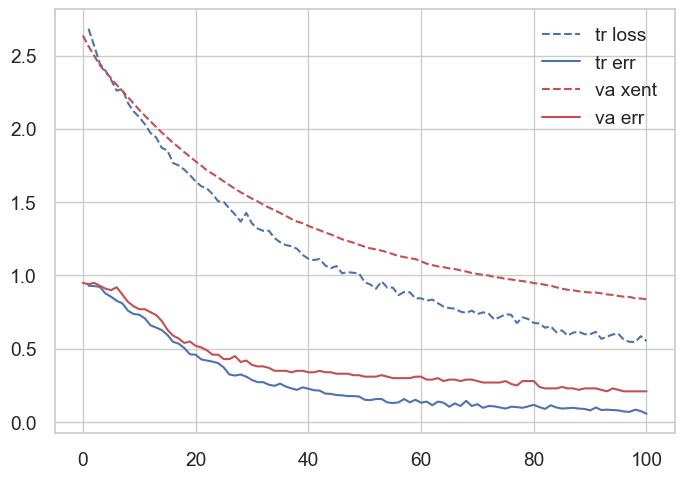

In [26]:
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet10_1k['epochs'], best_info_resnet10_1k['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

In [27]:
# if os.path.exists(PROB1_res_file):
#     with open(PROB1_res_file, 'rb') as f:
#         results = pickle.load(f)
# else:
#     results = dict()

# results[(src_dataset, arch)] = best_model, best_info

# with open(PROB1_res_file, 'w') as f:
#     f.save(results)


**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

In [28]:
# DONE do tuning expts for Resnet10, CUB
if PROB1_EXPERIMENTS:
    seed = 42
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10, best_info_resnet10 = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.001,
        l2pen_mag = 0.1,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [02:31<00:00,  1.50s/it, tr_xent=0.39, tr_err=0.075, va_xent=0.985, va_err=0.33, batch_done=7]  

Finished after epoch 100, best epoch=99
best va_xent 0.979
best tr_err 0.077
best va_err 0.340


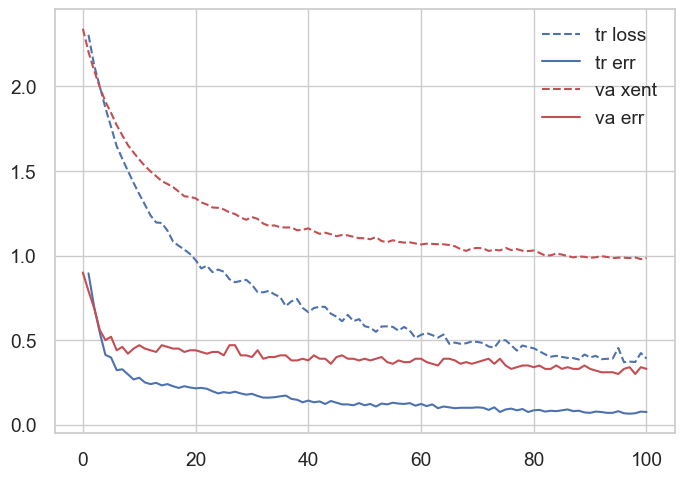

In [29]:
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet10['epochs'], best_info_resnet10['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet10['epochs'], best_info_resnet10['va']['err'], '-', color='r', label='va err')
plt.legend();

In [30]:
# DONE do tuning expts for Resnet26, ImageNet1k
if PROB1_EXPERIMENTS:
    seed = 42
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed)

    best_model_resnet26_1k, best_info_resnet26_1k = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.0001,
        l2pen_mag = 0.01,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [05:15<00:00,  3.12s/it, tr_xent=0.629, tr_err=0.0725, va_xent=0.891, va_err=0.2, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.891
best tr_err 0.072
best va_err 0.200


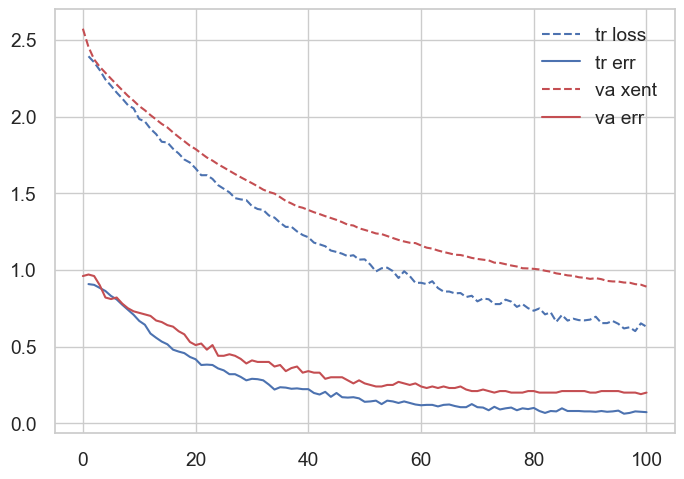

In [31]:
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet26_1k['epochs'], best_info_resnet26_1k['va']['err'], '-', color='r', label='va err')
plt.legend();

In [32]:
# TODO do tuning expts for Resnet26, CUB
if PROB1_EXPERIMENTS:
    seed = 42
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet26', n_trainable_layers=1, seed=seed)

    best_model_resnet26_cub, best_info_resnet26_cub = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.001,
        l2pen_mag = 0.01,
        data_order_seed=seed,
        )


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [05:27<00:00,  3.24s/it, tr_xent=0.341, tr_err=0.0475, va_xent=0.846, va_err=0.2, batch_done=7] 

Finished after epoch 100, best epoch=90
best va_xent 0.832
best tr_err 0.052
best va_err 0.200


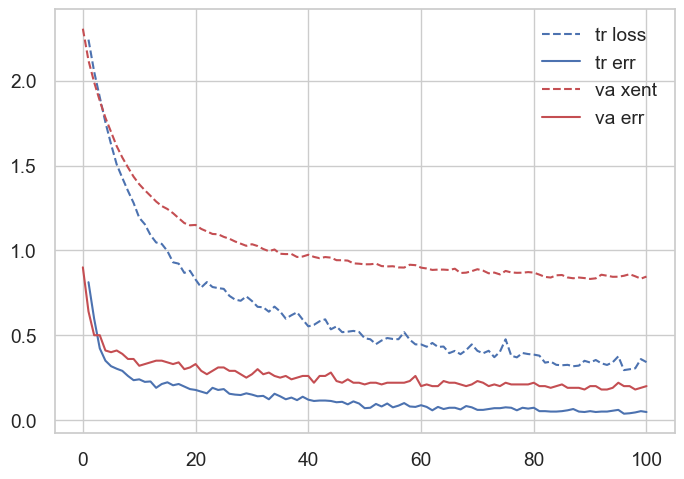

In [33]:
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_resnet26_cub['epochs'], best_info_resnet26_cub['va']['err'], '-', color='r', label='va err')
plt.legend();

# Problem 1 Analysis and Plotting

In [34]:
# # Create dummy results so we can show what kind of plots we want
dummy_result = {}

eps_1k = np.arange(100)  
# Ensure that metric arrays have the same length as their respective epochs
dummy_result[('ResNet10', 'ImageNet1k')] = dict(
    lr=0.0001,
    l2pen_mag=0.01,
    seed=42,
    epochs=eps_1k,
    tr=dict(
        loss=best_info_resnet10_1k['tr']['loss'][:len(eps_1k)],  
        xent=best_info_resnet10_1k['tr']['xent'][:len(eps_1k)],
        err=best_info_resnet10_1k['tr']['err'][:len(eps_1k)],
    ),
    va=dict(
        xent=best_info_resnet10_1k['va']['xent'][:len(eps_1k)], 
        err=best_info_resnet10_1k['va']['err'][:len(eps_1k)],
    ),
    best_epoch=99,
    best_va_loss=0.838,
)


eps_cub = np.arange(100) 
# Ensure that metric arrays have the same length as their respective epochs
dummy_result[('ResNet10', 'CUB')] = dict(
    lr=0.001,
    l2pen_mag=0.1,
    seed=42,
    epochs=eps_cub,
    tr=dict(
        loss=best_info_resnet10['tr']['loss'][:len(eps_cub)], 
        xent=best_info_resnet10['tr']['xent'][:len(eps_cub)],
        err=best_info_resnet10['tr']['err'][:len(eps_cub)],
    ),
    va=dict(
        xent=best_info_resnet10['va']['xent'][:len(eps_cub)],  
        err=best_info_resnet10['va']['err'][:len(eps_cub)],
    ),
    best_epoch=99,  # Adjusted based on actual data
    best_va_loss=0.979,
)

## Figure 1a: Loss over Epochs

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

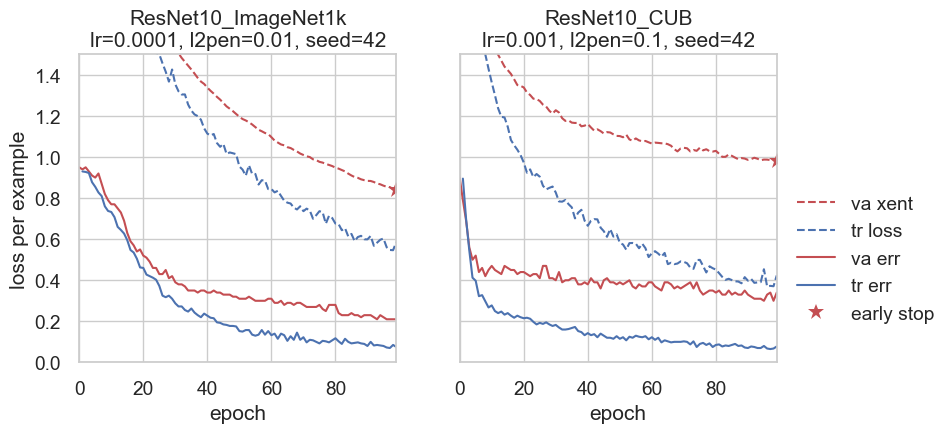

In [35]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
        ('ResNet10','ImageNet1k'),
        ('ResNet10','CUB'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)
    info = dummy_result[key]
    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [36]:
src_acc = {}
src_acc[('ResNet10', 'ImageNet1k')] = 0.68 # DONE FIXME
src_acc[('ResNet26', 'ImageNet1k')] = 0.74 # DONE FIXME

src_acc[('ResNet10', 'CUB')] = 0.72 # DONE FIXME
src_acc[('ResNet26', 'CUB')] = 0.77 # DONE FIXME

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [37]:
tar_acc = {}

tar_acc[('ResNet10', 'ImageNet1k')] = eval_acc(best_model_resnet10_1k, device, test_loader)
tar_acc[('ResNet26', 'ImageNet1k')] = eval_acc(best_model_resnet26_1k, device, test_loader)  

tar_acc[('ResNet10', 'CUB')] = eval_acc(best_model_resnet10, device, test_loader)
tar_acc[('ResNet26', 'CUB')] = eval_acc(best_model_resnet26_cub, device, test_loader)

# Print the updated target accuracies
print("Target Accuracies:")
print(tar_acc)

Target Accuracies:
{('ResNet10', 'ImageNet1k'): 0.7428571428571429, ('ResNet26', 'ImageNet1k'): 0.7714285714285715, ('ResNet10', 'CUB'): 0.5, ('ResNet26', 'CUB'): 0.5}


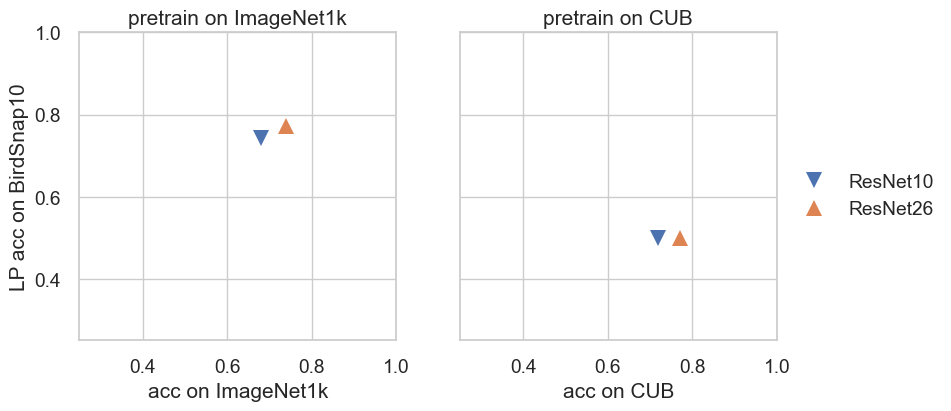

In [38]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(arch, src_dataset)]
    cur_src_acc = src_acc[(arch, src_dataset)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [39]:
if PROB1_EXPERIMENTS:
    seed = 42
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)

    best_model_resnet10_1k, best_info_resnet10_1k = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.0001,
        l2pen_mag = 0.01,
        data_order_seed=seed,
        )

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [02:59<00:00,  1.77s/it, tr_xent=0.553, tr_err=0.0575, va_xent=0.838, va_err=0.21, batch_done=7]

Finished after epoch 100, best epoch=100
best va_xent 0.838
best tr_err 0.058
best va_err 0.210


In [40]:
import copy

ft_seed = 10

resnet10_ft = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=3, seed=ft_seed)

resnet10_ft.load_state_dict(copy.deepcopy(best_model_resnet10_1k.state_dict()))

# Fine-tune the model with the new hyperparameters
best_model_ft, best_info_ft = train.train_model(
    resnet10_ft, device, train_loader, val_loader,
    n_epochs=80,
    lr=0.00001,
    l2pen_mag=0.1,
    data_order_seed=ft_seed
)

Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


100%|██████████| 81/81 [02:31<00:00,  1.87s/it, tr_xent=0.419, tr_err=0.055, va_xent=0.738, va_err=0.18, batch_done=7] 

Finished after epoch 80, best epoch=79
best va_xent 0.735
best tr_err 0.055
best va_err 0.160


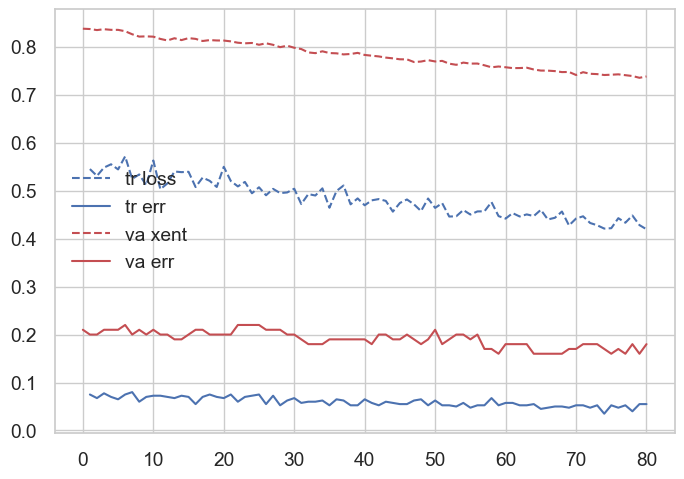

In [41]:
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_ft['epochs'], best_info_ft['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_ft['epochs'], best_info_ft['va']['err'], '-', color='r', label='va err')
plt.legend();

In [42]:
ft_acc = eval_acc(best_model_ft, device, test_loader)
print(ft_acc)

0.7857142857142857


In [43]:
# eps = np.arange(20)

P2_dummy_result = {}

# Phase 1, copy hard work from Problem 1
P2_dummy_result[('ResNet10', 'ImageNet1k','phase1')] = dummy_result[('ResNet10', 'ImageNet1k')]

eps_ft = np.arange(80)
P2_dummy_result[('ResNet10', 'ImageNet1k','phase2')] = dict(
    lr = 0.0001,
    l2pen_mag = 0.1,
    seed = 42,
    epochs=np.arange(80),
    tr=dict(
        loss=best_info_ft['tr']['loss'][:len(eps_ft)],
        err=best_info_ft['tr']['err'][:len(eps_ft)]
    ),
    va=dict(
        xent=best_info_ft['va']['xent'][:len(eps_ft)],
        err=best_info_ft['va']['err'][:len(eps_ft)],
    ),
    best_epoch=80,
    best_va_loss=0.736,
    test_acc=0.58375,
)

## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

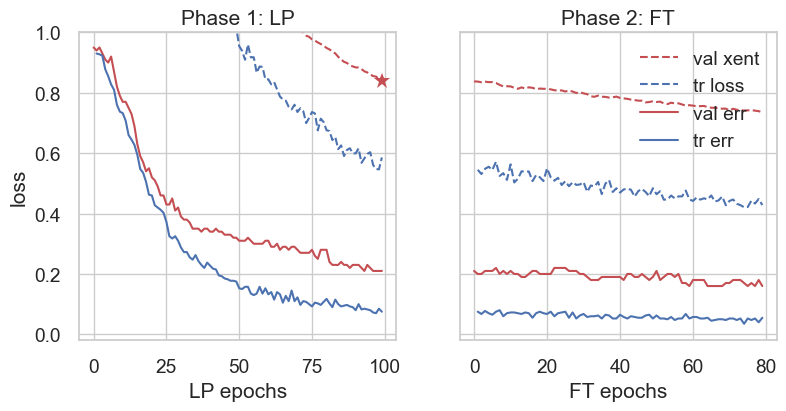

In [44]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase2')]

# Only show LP phase until early stop occurs
eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].set_title("Phase 2: FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('FT epochs');
axgrid[1].legend(loc='upper right');


## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [45]:
# DONE compute test acc after the LP phase
lp_acc = eval_acc(best_model_resnet10_1k, device, test_loader)
print(lp_acc)

0.7428571428571429


In [46]:
# DONE compute test acc after the FT-3 phase
ft_3_acc = eval_acc(best_model_ft, device, test_loader)
print(ft_3_acc)

0.7857142857142857
